In [14]:
"""this code loads all high res wind fields and extracts a structured low res version of them (sparsely measured) and then interpolates them
to a 13*13 pixel version """

from scipy.interpolate import griddata
import numpy as np
import os
from concurrent.futures import ProcessPoolExecutor
import time




import_directory = "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/X_test"
output_directory = "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_LowRes/3by3/X_test_3"

os.makedirs(output_directory, exist_ok=True)

file_list = sorted(os.listdir(import_directory))

# Assuming a 10 by 10 grid of UAVs
#extract_points=[70, 210, 350] #Assuming 3 by 3 grid of UAVs
extract_points=[90, 230, 390]
# extract_points=[41, 124, 207, 291, 375] #Assuming 5 by 5 grid of UAVs
#extract_points=[29, 90, 150, 210, 270, 330, 387] #Assuming a 7 by 7 grid of UAVs
# extract_points=[19, 61, 102, 143, 184, 224, 265, 307, 348, 389] #Assuming a 10 by 10 grid of UAVs

sampling_coords = np.array([(i, j) for i in np.array(extract_points) for j in np.array(extract_points)])
sampled_x = sampling_coords[:, 0]
sampled_y = sampling_coords[:, 1]

# Create a regular grid for the low-resolution image
grid_x, grid_y = np.mgrid[0:416:13j, 0:416:13j]

num_channel = 4

def regular_grid_sampling(array, sampling_coords):
    return np.array([array[x, y] for x, y in sampling_coords])

def process_file(file_name):
    print(f"Processing {file_name}...")
    wind_map = np.load(os.path.join(import_directory, file_name))
    low_res = np.zeros((num_channel, grid_x.shape[0], grid_y.shape[1]))

    for channel in range(num_channel):
        sampled_values = regular_grid_sampling(wind_map[channel], sampling_coords)

        # Interpolate the sampled points onto the grid using linear spline interpolation
        grid_z = griddata(sampling_coords, sampled_values, (grid_x, grid_y), method='linear')

        # Fill in any NaN values with the nearest neighbor interpolation (as a fallback)
        nan_mask = np.isnan(grid_z)
        if np.any(nan_mask):
            grid_z[nan_mask] = griddata(sampling_coords, sampled_values, (grid_x[nan_mask], grid_y[nan_mask]), method='nearest')

        low_res[channel] = grid_z

    np.save(os.path.join(output_directory, file_name), low_res)
    print(f"{file_name} Done!")

# Parallel processing
with ProcessPoolExecutor() as executor:
    executor.map(process_file, file_list)


Processing 0.npy...Processing 1.npy...

Processing 100.npy...Processing 1000.npy...Processing 10.npy...Processing 1002.npy...Processing 1003.npy...Processing 1005.npy...Processing 1008.npy...Processing 1004.npy...Processing 1009.npy...Processing 1006.npy...

Processing 1007.npy...


Processing 1010.npy...



0.npy Done!Processing 1001.npy...


1.npy Done!
10.npy Done!
1007.npy Done!1003.npy Done!1000.npy Done!1009.npy Done!
1004.npy Done!Processing 1012.npy...100.npy Done!
Processing 1011.npy...

Processing 101.npy...

1006.npy Done!1005.npy Done!

Processing 1016.npy...Processing 1014.npy...
Processing 1015.npy...Processing 1018.npy...Processing 1013.npy...

Processing 1017.npy...


Processing 102.npy...

Processing 1019.npy...1010.npy Done!
1018.npy Done!
1002.npy Done!
1016.npy Done!
1012.npy Done!1011.npy Done!1001.npy Done!
101.npy Done!1008.npy Done!
1015.npy Done!1014.npy Done!Processing 1021.npy...

Processing 1022.npy...

Processing 1020.npy...




1013.npy Done!Processing 102

In [6]:
"""Randomly sensing the environment and creating 13*13 low res images """

from scipy.interpolate import griddata
import numpy as np
import os
from concurrent.futures import ProcessPoolExecutor
import time

import_directory = "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_highres/X_test"
output_directory = "/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_pb_RandomSampled/25points/X_test_3"

os.makedirs(output_directory, exist_ok=True)

file_list = sorted(os.listdir(import_directory))

# Number of sampled points 
num_points = 25

# Random Sampling power
power=0.7


# Set a random seed based on the current time for variability
random_seed = int(time.time())
np.random.seed(random_seed)
# Random sampling
def random_sampling(wind_map, num_points):
    prob_distribution=abs(wind_map)**power   
    prob_distribution/=np.sum(prob_distribution) #normalise
    sampled_points = np.random.choice(wind_map.size, size=num_points, replace=False, p=prob_distribution.flatten())
    sampled_coords = [(pt // wind_map.shape[1], pt % wind_map.shape[1]) for pt in sampled_points]
    return np.array(sampled_coords)

# Create a regular grid for the low-resolution image
grid_x, grid_y = np.mgrid[0:416:13j, 0:416:13j]

num_channel = 4

def process_file(file_name):
    print(f"Processing {file_name}...")
    wind_map = np.load(os.path.join(import_directory, file_name))
    low_res = np.zeros((num_channel, grid_x.shape[0], grid_y.shape[1]))

    # Perform random sampling once per file
    sampling_coords = random_sampling(wind_map[4], num_points)
    sampled_x = sampling_coords[:, 0]
    sampled_y = sampling_coords[:, 1]

    for channel in range(num_channel):
        sampled_values = wind_map[channel, sampled_x, sampled_y]

        #adding noise 
        # noise_level = 0.5  # 30% noise level
        # noise = np.random.normal(0, noise_level, sampled_values.shape)
        # sampled_values = sampled_values * (1 + noise)


        # Interpolate the sampled points onto the grid using linear spline interpolation
        grid_z = griddata(sampling_coords, sampled_values, (grid_x, grid_y), method='linear')

        # Fill in any NaN values with the nearest neighbor interpolation (as a fallback)
        nan_mask = np.isnan(grid_z)
        if np.any(nan_mask):
            grid_z[nan_mask] = griddata(sampling_coords, sampled_values, (grid_x[nan_mask], grid_y[nan_mask]), method='nearest')

        low_res[channel] = grid_z

    np.save(os.path.join(output_directory, file_name), low_res)
    print(f"{file_name} Done!")

# Parallel processing
with ProcessPoolExecutor() as executor:
    executor.map(process_file, file_list)


Processing 0.npy...Processing 100.npy...
Processing 1.npy...
Processing 10.npy...

0.npy Done!Processing 1007.npy...Processing 1006.npy...Processing 1010.npy...Processing 1005.npy...Processing 1002.npy...Processing 1009.npy...Processing 1003.npy...Processing 1000.npy...
Processing 1008.npy...Processing 1001.npy...
Processing 1004.npy...
Processing 101.npy...


1.npy Done!Processing 1011.npy...






Processing 1012.npy...


10.npy Done!100.npy Done!1007.npy Done!
1011.npy Done!1006.npy Done!
1000.npy Done!Processing 1013.npy...
1003.npy Done!1004.npy Done!
1008.npy Done!
1012.npy Done!1009.npy Done!Processing 1014.npy...1005.npy Done!1010.npy Done!1002.npy Done!Processing 1015.npy...
101.npy Done!








1001.npy Done!

Processing 1019.npy...
Processing 1024.npy...Processing 1021.npy...
Processing 1025.npy...Processing 1017.npy...
Processing 1022.npy...1015.npy Done!Processing 1016.npy...1013.npy Done!
Processing 1023.npy...Processing 1020.npy...




Processing 102.npy...1014.npy Done

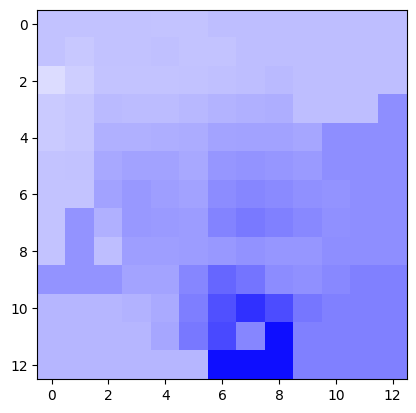

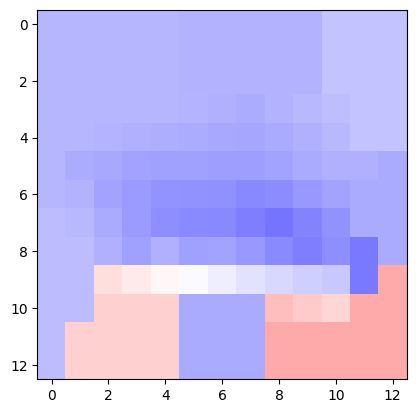

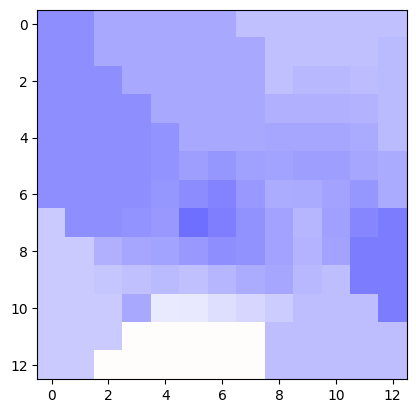

In [8]:
import numpy as np
import matplotlib.pyplot as plt
l=15
a=np.load(f"/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_pb_RandomSampled/16points/X_test_0/{l}.npy")
b=np.load(f"/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_pb_RandomSampled/16points/X_test_1/{l}.npy")
c=np.load(f"/home/availab-dl1/Sandboxes/Mohammad/FireWind-Dataset/FireWind_pb_RandomSampled/16points/X_test_2/{l}.npy")

plt.imshow(a[0],vmin=0,vmax=13,cmap="bwr")
plt.show()
plt.imshow(b[0],vmin=0,vmax=13,cmap="bwr")
plt.show()
plt.imshow(c[0],vmin=0,vmax=13,cmap="bwr")
plt.show()
